In [1]:
#Import all libraries
from unet_model import *
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Set parameters
im_width = 128
im_height = 128
border = 5

In [3]:
#Get all image files
ids = next(os.walk("./data/images"))[2] 
print("No. of images = ", len(ids))

No. of images =  1965


In [4]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [5]:
#Convert images & masks to arrays
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("./data/images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask_orig = img_to_array(load_img("./data/masks_inverted/"+id_, grayscale=True))
    mask = resize(mask_orig, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

HBox(children=(IntProgress(value=0, max=1965), HTML(value='')))

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [6]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
#Calculate test size ratio
test_size = (X_valid.shape[0]/X_train.shape[0])
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=test_size, random_state=42)

In [7]:
#Test Ratios
test_size
X_train.shape[0]
#y_train.shape[0]
#X_valid.shape[0]
#y_valid.shape[0]
#X_test.shape[0]
#y_test.shape[0]

1571

In [8]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy'])

In [56]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

In [10]:
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

In [ ]:
#Plot Loss vs Epoch
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [ ]:
#Plot Accuracy vs Epoch
plt.figure(figsize=(8, 8))
acc = results.history['acc']
val_acc = results.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


### Inference

In [11]:
# load the best model
model.load_weights('model_aug_16f_wbn.h5')

In [12]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

197/197 [==============================] - 10s 52ms/step


[0.03573446036292817, 0.9287025722755393]

In [13]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_test, y_test, verbose=1)

197/197 [==============================] - 10s 52ms/step


[0.03359562642683232, 0.9261697685052901]

In [14]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)
preds_test = model.predict(X_test, verbose=1)

197/197 [==============================] - 11s 54ms/step


In [15]:
# Threshold predictions
threshold =.408
preds_train_t = (preds_train > threshold).astype(np.uint8)
preds_val_t = (preds_val > threshold).astype(np.uint8)
preds_test_t = (preds_test > threshold).astype(np.uint8)

In [16]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='autumn')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze(),cmap = 'autumn')
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(),cmap = 'autumn', vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted Mask')
    
    ax[3].imshow(binary_preds[ix].squeeze(), cmap = 'autumn',vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted Binary Mask');

### Predictions on test set

122
IOU: 0.9573918657198193


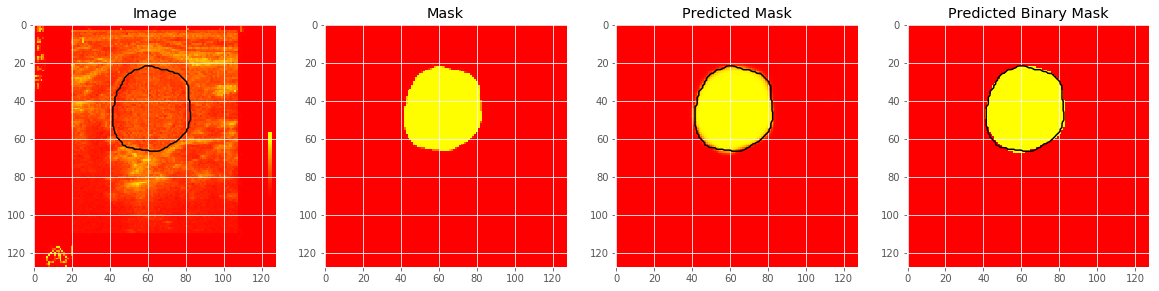

In [100]:
ix = random.randint(0, len(preds_val))
print(ix)
plot_sample(X_test, y_test, preds_test, preds_test_t,ix=ix)


threshold =.4082
binarize = .1
intersection = np.logical_and(y_test[ix].squeeze() > binarize, preds_test[ix].squeeze() > threshold)
union = np.logical_or(y_test[ix].squeeze() > binarize, preds_test[ix].squeeze() > threshold)
iou=np.sum(intersection) / np.sum(union)
print('IOU:',iou)

#Save array to DF
#df_valid = pd.DataFrame(y_valid[ix].squeeze())
#df_valid.to_csv('df_valid.csv')

In [47]:
#Make sure mask is binary for IOU calculation
size = len(y_valid)
y_train_mod = np.zeros((size,im_width,im_height),dtype=np.int32)
y_train_mod = y_train.squeeze() > binarize
    
#Set up Predicted Mask for IOU calculation
preds_train_mod = np.zeros((size,im_width,im_height),dtype=np.int32)
preds_train_sq = preds_train.squeeze()

In [48]:
thresholds = np.linspace(0.0001, 1, 50)
ious = np.zeros(len(thresholds))
count = 0
for threshold in thresholds:
    for i in range(size):
        preds_train_mod[i,:,:] = np.where(preds_train_sq[i,:,:] > threshold, 1, 0)
    iou = np.zeros(size)
    for i in range(size):
        intersection = np.logical_and(y_train_mod[i,:,:], preds_train_mod[i,:,:])
        union = np.logical_or(y_train_mod[i,:,:], preds_train_mod[i,:,:])
        iou[i]=(np.sum(intersection) / np.sum(union))
    ious[count] = (np.mean(iou))
    count = count + 1

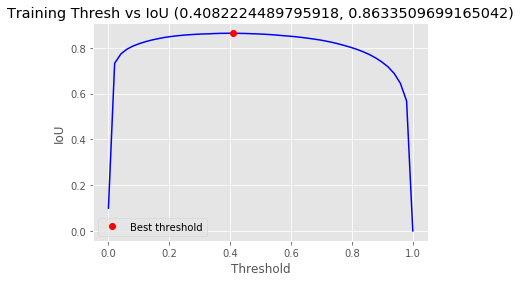

In [49]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
 
plt.plot(thresholds, ious,"b")
plt.plot(threshold_best, iou_best, "ro", label="Best threshold",)
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Training Thresh vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [50]:
#Make sure mask is binary for IOU calculation
size = len(y_valid)
y_valid_mod = np.zeros((size,im_width,im_height),dtype=np.int32)
y_valid_mod = y_valid.squeeze() > binarize
    
#Set up Predicted Mask for IOU calculation
preds_val_mod = np.zeros((size,im_width,im_height),dtype=np.int32)
preds_val_sq = preds_val.squeeze()

In [51]:
thresholds = np.linspace(0.0001, 1, 50)
ious = np.zeros(len(thresholds))
count = 0
for threshold in thresholds:
    for i in range(size):
        preds_val_mod[i,:,:] = np.where(preds_val_sq[i,:,:] > threshold, 1, 0)
    iou = np.zeros(size)
    for i in range(size):
        intersection = np.logical_and(y_valid_mod[i,:,:], preds_val_mod[i,:,:])
        union = np.logical_or(y_valid_mod[i,:,:], preds_val_mod[i,:,:])
        iou[i]=(np.sum(intersection) / np.sum(union))
    ious[count] = (np.mean(iou))
    count = count + 1

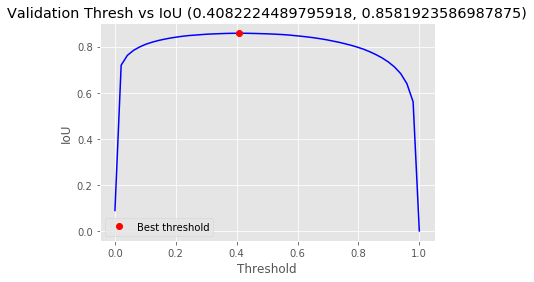

In [52]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
 
plt.plot(thresholds, ious,"b")
plt.plot(threshold_best, iou_best, "ro", label="Best threshold",)
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Validation Thresh vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [53]:
#Make sure mask is binary for IOU calculation
size = len(y_test)
y_test_mod = np.zeros((size,im_width,im_height),dtype=np.int32)
y_test_mod = y_test.squeeze() > binarize
    
#Set up Predicted Mask for IOU calculation
preds_test_mod = np.zeros((size,im_width,im_height),dtype=np.int32)
preds_test_sq = preds_test.squeeze()

In [54]:
thresholds = np.linspace(0.0001, 1, 50)
ious = np.zeros(len(thresholds))
count = 0
for threshold in thresholds:
    for i in range(size):
        preds_test_mod[i,:,:] = np.where(preds_test_sq[i,:,:] > threshold, 1, 0)
    iou = np.zeros(size)
    for i in range(size):
        intersection = np.logical_and(y_test_mod[i,:,:], preds_test_mod[i,:,:])
        union = np.logical_or(y_test_mod[i,:,:], preds_test_mod[i,:,:])
        iou[i]=(np.sum(intersection) / np.sum(union))
    ious[count] = (np.mean(iou))
    count = count + 1

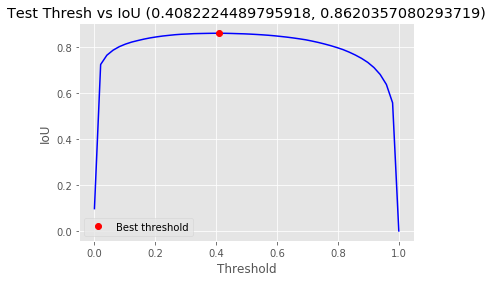

In [55]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
 
plt.plot(thresholds, ious,"b")
plt.plot(threshold_best, iou_best, "ro", label="Best threshold",)
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Test Thresh vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()